In [9]:
import torch
import torch.nn as nn
import numpy as np
from functools import partial

from torch.optim.lr_scheduler import StepLR

from model import NN
from model import save_model, load_model
from functions import gaussian_loss_function, get_weights_vector
from train import training_routine_isoperimetric
from visuals import plot_transformed_shape_and_grid, compute_uniform_circle_density


from pathlib import Path

from matplotlib import pyplot as plt

In [2]:
torch.set_default_dtype(torch.float32)
torch.manual_seed(2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

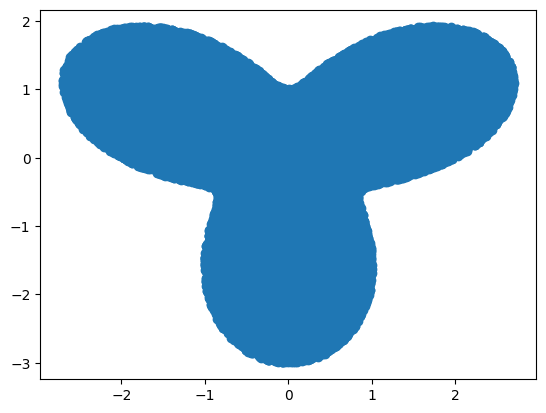

In [3]:
def generate_ellipse(max_num = 10000, scale=(0.5,0.2), device='cpu'):
    data = (torch.rand((max_num,2), device=device)-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale, device=device)
    return data

def generate_star(max_num = 10000, n_edges = 5, device='cpu'):
    data = generate_ellipse(max_num, scale=(3,3), device=device)
    angles = torch.arctan2(data[:,1],data[:,0])
    max_amplitude = torch.sin(n_edges*angles)+2
    amplitude = torch.sum(data**2,axis=1)**0.5
    data = data[amplitude <= max_amplitude]
    return data

inner_points = generate_star(max_num=100000, n_edges=3, device=device)
plt.scatter(np.array(inner_points.cpu())[:,0], np.array(inner_points.cpu())[:,1])

C:\Users\Admin\AppData\Local\Temp\ipykernel_30112\1060286107.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_angles = torch.atan2(torch.tensor(star)[:,1], torch.tensor(star)[:,0])


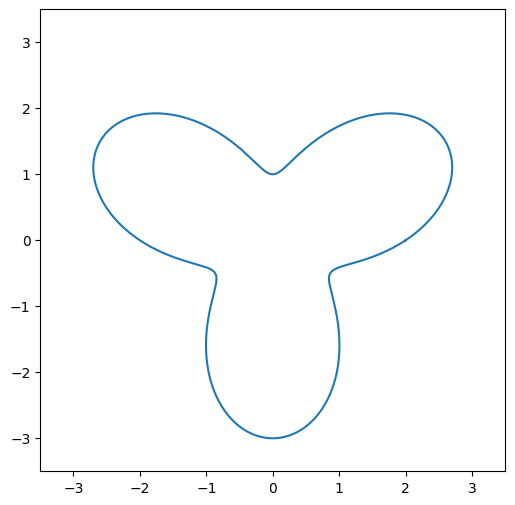

In [4]:
num_edges = 3

angles = np.linspace(0, 2*np.pi, 20000)
circle = np.stack((np.cos(angles), np.sin(angles)), axis=1)
amplitude = np.sin(num_edges*angles)+2
star = circle*amplitude.reshape(-1,1)

fig, ax = plt.subplots(figsize=(6, 6))
plt.xlim((-3.5,3.5))
plt.ylim((-3.5,3.5))
ax.plot(star[:,0], star[:,1], '-')


star = torch.tensor(star, device=device, dtype=torch.float32)
target_angles = torch.atan2(torch.tensor(star)[:,1], torch.tensor(star)[:,0])


In [181]:
def save_model(model, data = 'ellipse', checkpoint_number=1):
    checkpoints_dir= './acl_isoperimetric/'
    save_path = Path(checkpoints_dir) / Path("{}/experiment{}.pth".format(data, checkpoint_number))
    save_path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), save_path)
    np.savez(f"{checkpoints_dir}/{data}/split_indices{checkpoint_number}", [model.layers[i].split_index for i in range(len(model.layers))])
    print("Saved checkpoint:", save_path)

save_model(model, data='3StarProj', checkpoint_number=1)
#model = load_model(num_coupling_layers=20, split_size_x1=1, nn_size=(1, 10), path=f"./acl_isoperimetric/3StarProj/experiment{1}.pth")

Saved checkpoint: acl_isoperimetric\3StarProj\experiment1.pth


In [5]:
model = NN(num_coupling_layers=20, split_size_x1=1, nn_size=(1, 10)).to(device)

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21736\1912804052.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(original_shape, device=device))


0

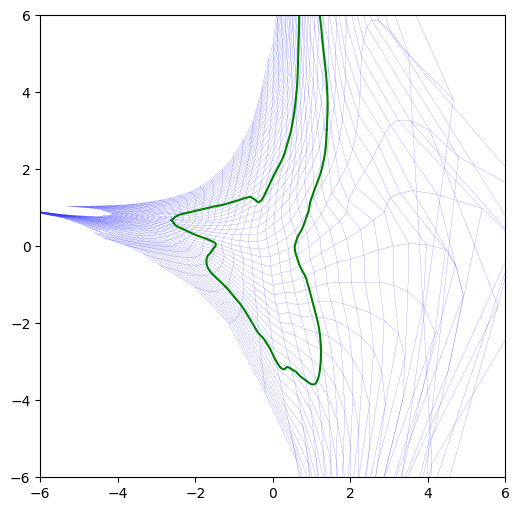

In [174]:
plot_transformed_shape_and_grid(model, device, star, grid_width=50,
                                             x_lim=(-6, 6), y_lim=(-6, 6),
                                             density_function=compute_uniform_circle_density, name='Init3Star.png')

In [11]:
%%time
losses = []

method = 0 # 0: projection, 1: loss term

for _ in range(0,300):
    v, b = training_routine_isoperimetric(model,device,
                                                outer_points=star, 
                                                inner_points=inner_points, 
                                                optimizer=optimizer, 
                                                method = method,
                                                penalty_weight=0.1)

    with torch.no_grad():
        plot_transformed_shape_and_grid(model, device, star, grid_width=30,
                                        x_lim=(-6, 6), y_lim=(-6, 6),
                                        density_function=compute_uniform_circle_density, name=f'IsoperimetricVideo3StarProj/{str(_).zfill(3)}_transformed.png')

    losses.append((v,b.detach()))
    if _ % 5 == 0:
        scheduler.step()


C:\Users\Admin\AppData\Local\Temp\ipykernel_21736\1912804052.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(original_shape, device=device))


0

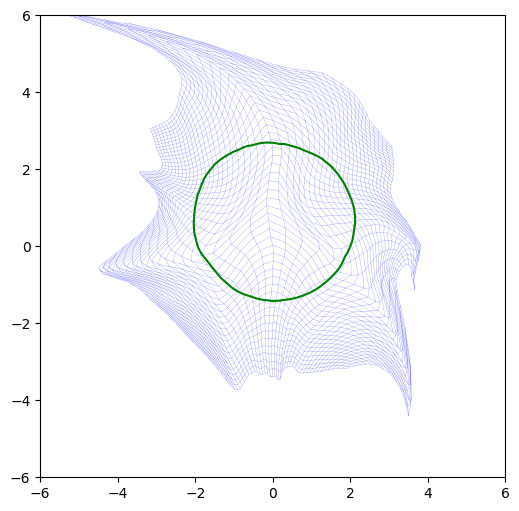

In [180]:
plot_transformed_shape_and_grid(model, device, star, grid_width=50,
                                             x_lim=(-6, 6), y_lim=(-6, 6),
                                             density_function=compute_uniform_circle_density, name='Transformed3StarProj.png')

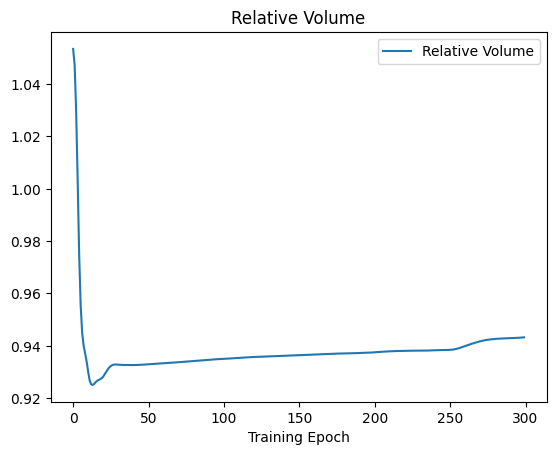

In [178]:
#losses = np.array(losses)
losses_cpu = [(l[0].cpu()) for l in losses]
plt.plot(losses_cpu[:])
plt.legend(['Relative Volume'])
plt.title('Relative Volume')
plt.xlabel('Training Epoch')

plt.savefig('RelativeVolumeLoss3StarProj.png')


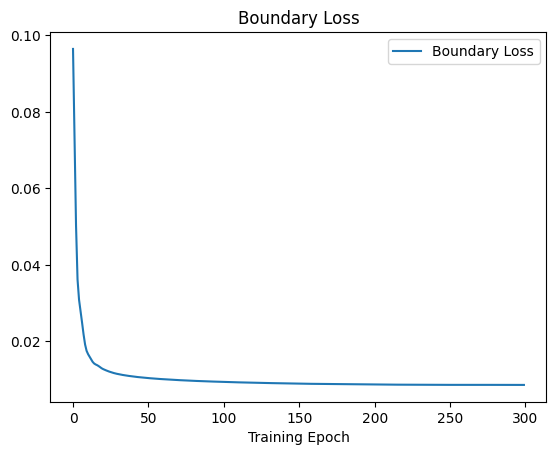

In [179]:
losses_cpu = [(l[1].detach().cpu()) for l in losses]
plt.plot(losses_cpu[:])
plt.legend(['Boundary Loss'])
plt.title('Boundary Loss')
plt.xlabel('Training Epoch')
plt.savefig('BoundaryLoss3StarProj.png')

In [655]:
import cv2
import os

image_folder = 'IsoperimetricVideo5Star'
video_name = 'video_5star.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()